# Summarization (PyTorch)

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] -qq
!pip install accelerate -qq
!pip install rouge_score -qq
!pip install nltk -qq

## Libraries

In [ ]:
from datasets import load_dataset, Dataset, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler

import torch
from torch.utils.data import DataLoader

import evaluate
import nltk
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np

## Args

In [ ]:
max_input_length = 512
max_target_length = 30
batch_size = 4
num_train_epochs = 3

## Download + Preprocess data

In [ ]:
vietnamese_train_ds, vietnamese_test_ds = load_dataset("wiki_lingua", "vietnamese", split=['train[:1000]', 'train[2000:2500]'])
english_train_ds, english_test_ds = load_dataset("wiki_lingua", "english", split=['train[:1000]', 'train[2000:2500]'])

def preporcess_columns_data_type(ds):
  ds = pd.DataFrame(data=ds['article'])
  ds['document'] = ds['document'].apply(lambda x: ' '.join(x))
  ds['summary'] = ds['summary'].apply(lambda x: ' '.join(x))

  return ds

def parse_dataset(ds_train, ds_test):
  ds_train = preporcess_columns_data_type(ds_train)
  ds_train = Dataset.from_pandas(ds_train)

  ds_test = preporcess_columns_data_type(ds_test)
  ds_test = Dataset.from_pandas(ds_test)

  return ds_train, ds_test

english_train_ds, english_test_ds = parse_dataset(english_train_ds, english_test_ds)
vietnamese_train_ds, vietnamese_test_ds = parse_dataset(vietnamese_train_ds, vietnamese_test_ds)
english_train_ds

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['section_name', 'document', 'summary'],
    num_rows: 1000
})

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
  sample = dataset.shuffle(seed=seed).select(range(num_samples))

  for example in sample:
      print(f"\n'>> Document: {example['document']}'")
      print(f"'>> Summary: {example['summary']}'")

show_samples(english_train_ds)


'>> Document: '
'>> Summary: '

'>> Document: '
'>> Summary: '

'>> Document: This is because grain is not a natural diet for cattle, and often causes more issues and illnesses than grass or hay does.  This is often one faultless preventative measure that a lot of producers can (and do) fall back on.  This helps with ease of digestion in the rumen, and also prevents the microbes in the rumen from digesting this high-concentrate ration too fast. Roughage should not be finely chopped, as this will often defeat the purpose of preventing acidosis.  Coarsely-chopped (or not chopped at all!) roughage is best. Then they over-eat to compensate for the loss of diet they missed during this interruption.  Often during extremely hot spells cattle won't eat during the day, then eat their hearts out at night when it's cooler. Thus, try to keep feeding schedules as routine as possible and keep feeding to several times a day to keep cattle from getting hungry between meals. Symptoms:  Cattle with acu

In [ ]:
dataset = DatasetDict()

def concat_two_datasets(dataset1, dataset2):
  dataset = concatenate_datasets([dataset1, dataset2])
  dataset = dataset.shuffle(seed=42)
  return dataset

dataset['train'] = concat_two_datasets(english_train_ds, vietnamese_train_ds)
dataset['test'] = concat_two_datasets(english_test_ds, vietnamese_test_ds)

show_samples(dataset['train'])


'>> Document: Nhúng khăn giấy vào bất cứ loại dầu ăn nào bạn có và đắp lên vết keo, để yên vài phút rồi bỏ ra. Bạn có thể chà hoặc cạo để loại bỏ phần lớn vết keo.  Các sản phẩm khác chứa dầu cũng có hiệu quả, chẳng hạn như dầu em bé, bơ lạc hoặc mayonnaise. Cẩn thận nếu quanh đó có các vật liệu thấm hút, chẳng hạn như thảm hoặc quần áo. Dầu có thể gây ra các vết ố bẩn. Nếu không yên tâm, bạn nên dùng muối nở thay cho dầu. Trộn một lượng dầu dừa và muối nở bằng nhau trong bát nhỏ. Trộn kỹ đến khi hỗn hợp có kết cấu như bột nhão. Nếu không có dầu dừa, bạn có thể thử trộn muối nở hoặc giấm với nước ấm. Nhúng giẻ mềm hoặc bàn chải đánh răng cũ vào hỗn hợp và phết lên khắp vết keo. Sau 30 phút đến 1 tiếng, bạn hãy quay lại để hoàn tất công việc làm sạch. Dấp nước ấm vào miếng giẻ sạch. Lượng keo còn sót sẽ bong ra khi bạn chà giẻ ẩm lên bề mặt món đồ. Dùng giẻ mềm hoặc khăn giấy để lau khô nước và kiểm tra vết keo còn sót. Bạn cũng có thể dùng dao hoặc dụng cụ cạo sơn để làm bong lượng ke

## EDA + Filter data

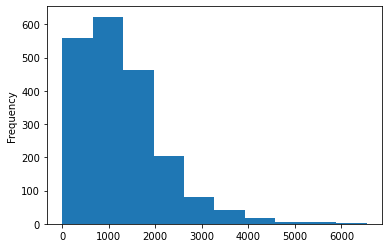

In [ ]:
def get_len(x):
  return len(x.split())

dataset.set_format("pandas")
df = dataset['train'][:]

df["length"] = df['document'].apply(get_len)

df["length"].sort_values(ascending=False).plot(kind='hist')

In [ ]:
dataset.reset_format()
dataset = dataset.filter(lambda x: get_len(x['document']) > 20 and get_len(x['document']) < 512)
dataset

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['section_name', 'document', 'summary', 'english_url', 'english_section_name'],
        num_rows: 248
    })
    test: Dataset({
        features: ['section_name', 'document', 'summary', 'english_url', 'english_section_name'],
        num_rows: 127
    })
})

## Metric

In [ ]:
rouge_score = evaluate.load("rouge")
nltk.download("punkt")

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["document"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

## Model

In [ ]:
model_checkpoint = "google/mt5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

## Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["document"],
        max_length=max_input_length,
        truncation=True)
    
    labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Dataset

In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched=True, batch_size=64)
tokenized_datasets = tokenized_datasets.remove_columns(
    dataset["train"].column_names)
tokenized_datasets.set_format("torch")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## DataLoader

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,)

eval_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=batch_size)

In [ ]:
sample = next(iter(train_dataloader))
sample

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[   364,   1292,    885,  ...,    394,   2591,      1],
        [   977,    924,    259,  ...,    330,   1292,      1],
        [   458,   2294,    273,  ...,      0,      0,      0],
        [   298,  13512, 101065,  ...,      0,      0,      0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[  352,  1269,   651,  1514,   297,   382,  2291,   394, 15975,   300,
           908,  1672,  1452,   330,  1292,   890,  5189,   259,   318,  1642,
           266,   259,  5079,   259,   793,  1552,   260,  1536,  2807,     1],
        [  366,  1593,   690,  2271,   330,  1629,   326,   908,  3517,   317,
           708,   262, 46467,   260, 40337, 12996,   273, 13160,   260,   412,
          1878,   259,   272,  2163, 13160,   300,   908,  1382,   276,     1],
        [  458,  2763,   259,   793,   266,   355,   268,  1292,   330,  2184,
       

## Optimizer

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader)

## Scheduler

In [ ]:
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

## Train + Eval

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    result ={key: round(value * 100, 4) for key, value in result.items()}
    print(f"Epoch {epoch}:", result)

  0%|          | 0/186 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 0: {'rouge1': 7.4506, 'rouge2': 1.3805, 'rougeL': 6.688, 'rougeLsum': 7.0708}
Epoch 1: {'rouge1': 8.0576, 'rouge2': 1.6008, 'rougeL': 7.2462, 'rougeLsum': 7.6796}
Epoch 2: {'rouge1': 8.1719, 'rouge2': 1.6008, 'rougeL': 7.3544, 'rougeLsum': 7.7304}


## Save model

In [ ]:
output_dir = 'mt5-finetuned-summarization'

accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
if accelerator.is_main_process:
  tokenizer.save_pretrained(output_dir)

## Inference

In [ ]:
def preprocess_txt(examples):
    model_inputs=tokenizer(
    examples,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt")

    return model_inputs
    
input_example = preprocess_txt(doc)

with torch.no_grad():
  generated_tokens =model.generate(
      input_ids=input_example["input_ids"],
      attention_mask=input_example["attention_mask"],
      num_beams=2,
      max_length=100,
      repetition_penalty=2.5,
      length_penalty=2.0,
      early_stopping=True,
      use_cache=True
  )

preds=[tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) 
         for gen_id in generated_tokens]

summary = "".join(preds)
print(summary)